# Mouth gesture recognition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from robot_vision.utils import plotting
from insightface.app import FaceAnalysis
from robot_vision.utils.plotting import draw_detections
import numpy as np
from skimage import transform

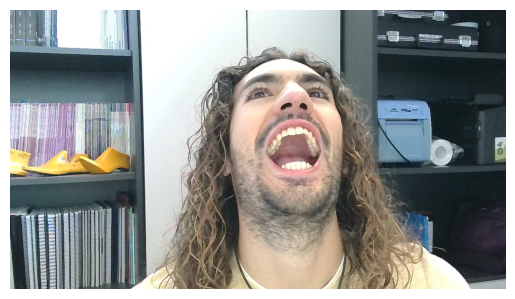

In [3]:
img_path = 'resources/mouth_open_up.jpg'
img = cv2.imread(img_path)
plotting.show_img(img)
x = 500
y = 100
size = 500

## In 2D space

### Get facial keypoints

Prepare recognizer:

In [4]:
allowed_modules = None# ['detection', 'landmark_2d_106']
app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'], allowed_modules=allowed_modules)
app.prepare(ctx_id=0, det_thresh=.5, det_size=(256,256))

C:\Users\Xavi\AppData\Roaming\Python\Python38\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Xavi/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Xavi/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Xavi/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Xavi/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Xavi/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

Get the face landmarks

In [5]:
faces = app.get(img)

# No faces
if len(faces) < 1:
    print('No faces detected')
    
keypoints = faces[0]['landmark_2d_106']

C:\Users\Xavi\AppData\Roaming\Python\Python38\site-packages\insightface\utils\transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


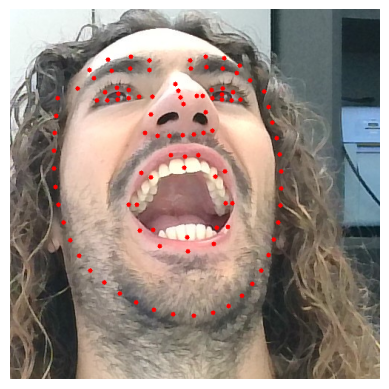

In [6]:
plotting.show_img(draw_detections(img, kps=keypoints)[y:y+size, x:x+size])

### Get specific keypoints

Get the mouth two coords

In [7]:
mouth = [keypoints[71], keypoints[53]]
mouth

[array([736.0731 , 299.09015], dtype=float32),
 array([740.8084 , 427.09036], dtype=float32)]

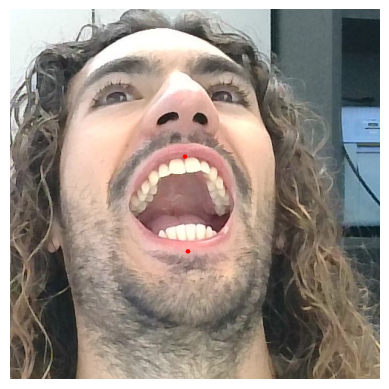

In [8]:
plotting.show_img(draw_detections(img, kps=mouth)[y:y+size, x:x+size])

Get the eyes two coords

In [9]:
eyes = [np.mean(keypoints[33:43], axis=0), np.mean(keypoints[87:97], axis=0)]
eyes

[array([645.6549 , 216.47432], dtype=float32),
 array([786.5066 , 216.58281], dtype=float32)]

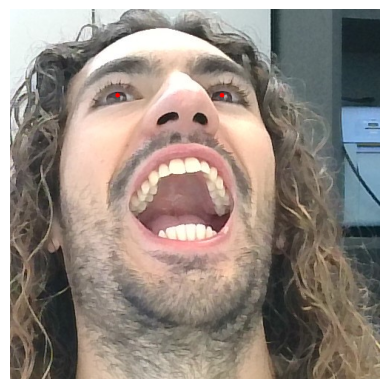

In [10]:
plotting.show_img(draw_detections(img, kps=eyes)[y:y+size, x:x+size])

Get the ears two coords

In [11]:
ears = [keypoints[16], keypoints[32]]
ears

[array([581.19324, 412.03336], dtype=float32),
 array([862.03796, 388.46826], dtype=float32)]

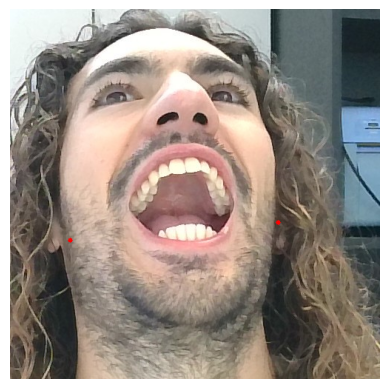

In [12]:
plotting.show_img(draw_detections(img, kps=ears)[y:y+size, x:x+size])

### Homography

Get destination points:

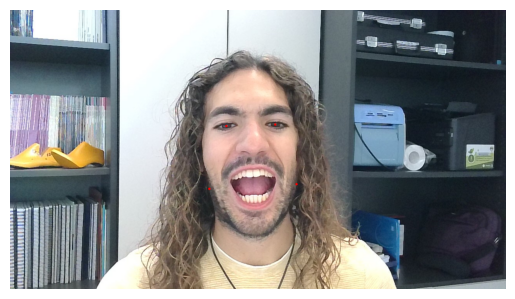

In [13]:
# Read normal image
img_path = 'resources/mouth_open_front.jpg'
img_normal = cv2.imread(img_path)

# Detect faces
faces = app.get(img_normal)

# No faces
if len(faces) < 1:
    print('No faces detected')

# Get keypoints
keypoints_normal = faces[0]['landmark_2d_106']

# Plot homography keypoints
homography_dst_points = [np.mean(keypoints_normal[33:43], axis=0), np.mean(keypoints_normal[87:97], axis=0), keypoints_normal[16], keypoints_normal[32]]
plotting.show_img(draw_detections(img_normal, kps=homography_dst_points))

Get source points:

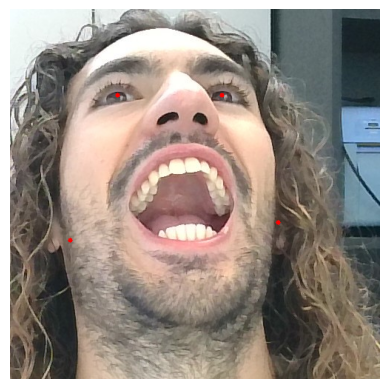

In [14]:
homography_src_points = [eyes[0], eyes[1], keypoints[16], keypoints[32]]
plotting.show_img(draw_detections(img, kps=homography_src_points)[y:y+size, x:x+size])

Compute homography transformation:

In [15]:
tform = transform.estimate_transform('projective', np.array(homography_src_points, dtype='float32'), np.array(homography_dst_points, dtype='float32'))

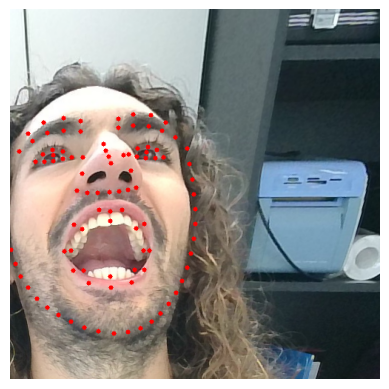

In [16]:
tf_img = (transform.warp(img, tform.inverse) * 255).astype(np.uint8)
tf_keypoints = tform(keypoints)
plotting.show_img(draw_detections(tf_img, kps=tf_keypoints)[y:y+size, x:x+size])

Normalize mouth distance by face size

In [17]:
FACTOR = 4

tf_mouth = [tf_keypoints[71], tf_keypoints[53]]
tf_eyes = [np.mean(tf_keypoints[33:43], axis=0), np.mean(tf_keypoints[87:97], axis=0)]

mouth_distance = FACTOR * np.linalg.norm(tf_mouth[1] - tf_mouth[0]) / np.linalg.norm(tf_mouth[0] - np.mean(tf_eyes, axis=0))
mouth_distance

5.354678164664527

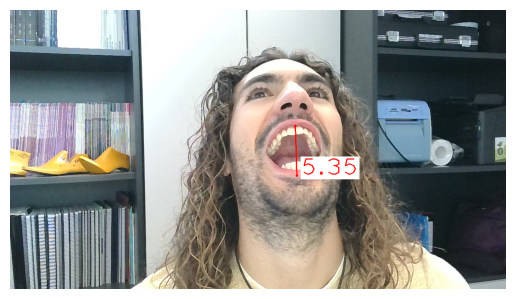

In [18]:
plotting.show_img(plotting.draw_detections(img, mouth_open=[mouth_distance, mouth[0][:2], mouth[1][:2]]))

# SPIGA

In [19]:
from spiga.inference.framework import SPIGAFramework
from spiga.inference.config import ModelConfig

from robot_vision.recognition import predefined
from robot_vision.utils.preprocessing import bbox_xy2wh

predefined.MODELS_FOLDER = '../robot_vision/models'
predefined.USER_FACES_FOLDER = '../robot_vision/user_faces'

d:\ProgramData\Anaconda3\envs\age_gender\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
dataset = 'wflw'
processor = SPIGAFramework(ModelConfig(dataset))

# Face bbox needed
face_detector=predefined.PREDEFINED_RECOGNIZERS['face_detection'][list(predefined.PREDEFINED_RECOGNIZERS['face_detection'].keys())[0]]()

SPIGA model loaded!


Model summary (fused): 268 layers, 68125494 parameters, 0 gradients


d:\ProgramData\Anaconda3\envs\age_gender\lib\site-packages\torch\nn\functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
d:\ProgramData\Anaconda3\envs\age_gender\lib\site-packages\torch\nn\functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


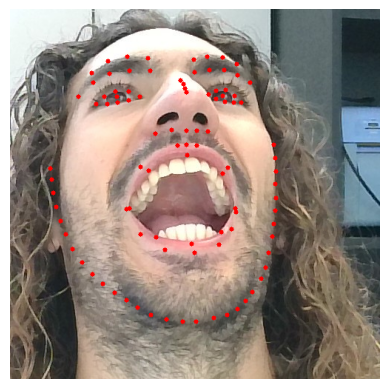

In [23]:

face_bbox = face_detector.get_bbox(img)[0]['detection']

# Case where no face found
if face_bbox is None:
    print('No face found')

face_bbox = bbox_xy2wh(face_bbox)

features = processor.inference(img, [face_bbox])
keypoints = np.array(features['landmarks'][0])
plotting.show_img(plotting.draw_detections(img, kps=keypoints)[y:y+size, x:x+size])

d:\ProgramData\Anaconda3\envs\age_gender\lib\site-packages\torch\nn\functional.py:4377: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
d:\ProgramData\Anaconda3\envs\age_gender\lib\site-packages\torch\nn\functional.py:4316: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


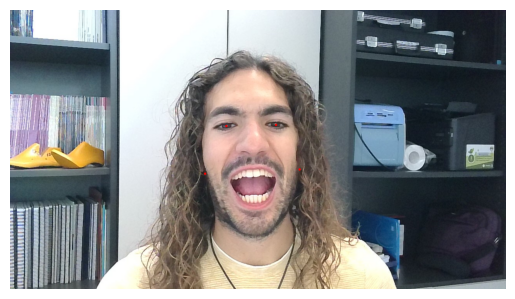

In [25]:
# Read normal image
img_path = 'resources/mouth_open_front.jpg'
img_normal = cv2.imread(img_path)

face_bbox = face_detector.get_bbox(img_normal)[0]['detection']

# Case where no face found
if face_bbox is None:
    print('No face found')

face_bbox = bbox_xy2wh(face_bbox)

features = processor.inference(img_normal, [face_bbox])
keypoints_normal = np.array(features['landmarks'][0])

# Plot homography keypoints
homography_dst_points = [np.mean(keypoints_normal[60:68], axis=0), np.mean(keypoints_normal[68:76], axis=0), keypoints_normal[5], keypoints_normal[27]]
plotting.show_img(draw_detections(img_normal, kps=homography_dst_points))

Get source points:

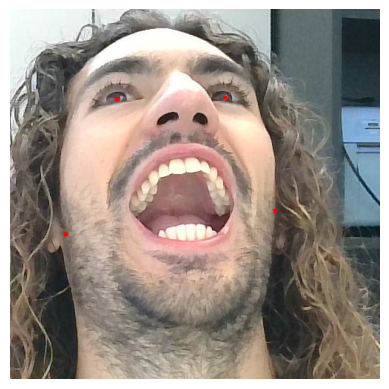

In [26]:
homography_src_points = [np.mean(keypoints[60:68], axis=0), np.mean(keypoints[68:76], axis=0), keypoints[5], keypoints[27]]
plotting.show_img(draw_detections(img, kps=homography_src_points)[y:y+size, x:x+size])

Compute homography transformation:

In [27]:
tform = transform.estimate_transform('projective', np.array(homography_src_points, dtype='float32'), np.array(homography_dst_points, dtype='float32'))

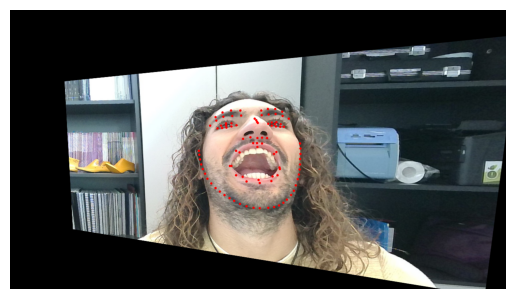

In [28]:
tf_img = (transform.warp(img, tform.inverse) * 255).astype(np.uint8)
tf_keypoints = tform(keypoints)
plotting.show_img(draw_detections(tf_img, kps=tf_keypoints))

In [29]:
FACTOR = 4

tf_mouth = [tf_keypoints[79], tf_keypoints[85]]
tf_eyes = [np.mean(tf_keypoints[60:68], axis=0), np.mean(tf_keypoints[68:76], axis=0)]

mouth_distance = FACTOR * np.linalg.norm(tf_mouth[1][1] - tf_mouth[0][1]) / np.linalg.norm(tf_mouth[0][1] - np.mean(tf_eyes, axis=0)[1])
mouth_distance

9.127623623507372

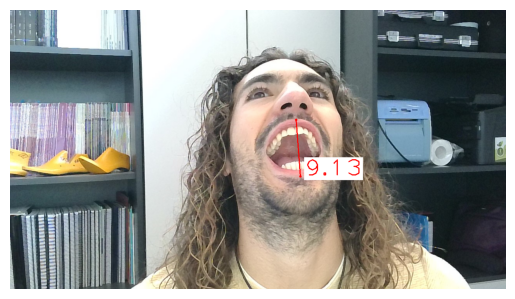

In [30]:
plotting.show_img(plotting.draw_detections(img, mouth_open=[mouth_distance, keypoints[79], keypoints[85]]))

In [31]:
import numpy as np
tf_mouth = np.array([[     559.12,      300.01], [     559.12,      300.01]])
tf_eyes = np.array([[     559.12,      300.01], [     559.12,      300.01]])
mouth_distance = 4 * np.linalg.norm(tf_mouth[1] - tf_mouth[0]) / np.linalg.norm(tf_mouth[0] - np.mean(tf_eyes, axis=0))

C:\Users\Xavi\AppData\Local\Temp\ipykernel_12892\1316874860.py:4: RuntimeWarning: invalid value encountered in scalar divide
  mouth_distance = 4 * np.linalg.norm(tf_mouth[1] - tf_mouth[0]) / np.linalg.norm(tf_mouth[0] - np.mean(tf_eyes, axis=0))
